# The Great Indian Hiring Hackathon
##### Solution Deepak Walia

### Overview
The current pandemic has dwindled the data science job market likewise recruiters are also facing difficulties filtering the right talent. To bridge this gap we bring a chance for the MachineHack community to compete for jobs with some of the key analytics players for a rewarding career in Data Science. In this competition, we are challenging the MachineHack community to come up with an algorithm to predict the price of retail items belonging to different categories. Foretelling the Retail price can be a daunting task due to the huge datasets with a variety of attributes ranging from Text, Numbers(floats, integers), and DateTime. Also, outliers can be a big problem when dealing with unit prices.

With a key focus on the Data Scientist role in an esteemed organization, this hackathon can help freshers and experienced folks prove their mettle and land up in a rewarding career.

By participating in this hackathon, every participant will be eligible for the Data Scientist job role by making sure their MachineHack Information with Resume is up to date.

Attribute Description:
- Invoice No - Invoice ID, encoded as Label
- StockCode - Unique code per stock, encoded as Label
- Description - The Description, encoded as Label
- Quantity - Quantity purchased
- InvoiceDate - Date of purchase
- UnitPrice - The target value, price of every product
- CustomerID - Unique Identifier for every Customer
- Country - Country of sales, encoded as Label


### Evaluation
What is the Metric In this competition? How is the Leaderboard Calculated ??
The submission will be evaluated using the RMSE metric. One can use np.sqrt(mean_squared_error(actual, predicted)) to calculate the same
This hackathon supports private and public leaderboards
The public leaderboard is evaluated on 70% of Test data
The private leaderboard will be made available at the end of the hackathon which will be evaluated on 100% Test data

In [1]:
import pandas as pd
import numpy as np
import ppscore as pps
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set(rc={'figure.figsize':(9,9)})
from category_encoders import target_encoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Read train and test dataset
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')

In [3]:
df_train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056.0,35
1,6349,1300,3682,6,2011-05-11 07:35:00,1.95,13098.0,35
2,16783,2178,1939,4,2011-11-20 13:20:00,5.95,15044.0,35
3,16971,2115,2983,1,2011-11-22 12:07:00,0.83,15525.0,35
4,6080,1210,2886,12,2011-05-06 09:00:00,1.65,13952.0,35


In [4]:
df_test.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country
0,3139,1709,1079,3,2011-02-22 15:22:00,16161.0,35
1,617,510,3457,1,2010-12-08 12:46:00,17341.0,35
2,14653,604,694,36,2011-10-25 13:53:00,15158.0,35
3,8634,1478,3473,2,2011-06-27 12:38:00,16033.0,35
4,15546,3216,871,1,2011-11-06 16:14:00,15351.0,35


# Exploratory Data Analysis

In [5]:
#Invoice Date will need to converted into datetime format. Description & Country provided in numeric codes.
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284780 entries, 0 to 284779
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    284780 non-null  int64  
 1   StockCode    284780 non-null  int64  
 2   Description  284780 non-null  int64  
 3   Quantity     284780 non-null  int64  
 4   InvoiceDate  284780 non-null  object 
 5   UnitPrice    284780 non-null  float64
 6   CustomerID   284780 non-null  float64
 7   Country      284780 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 17.4+ MB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122049 entries, 0 to 122048
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    122049 non-null  int64  
 1   StockCode    122049 non-null  int64  
 2   Description  122049 non-null  int64  
 3   Quantity     122049 non-null  int64  
 4   InvoiceDate  122049 non-null  object 
 5   CustomerID   122049 non-null  float64
 6   Country      122049 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 6.5+ MB


In [7]:
# No missing values in both train and test data
df_train.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [8]:
df_test.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
CustomerID     0
Country        0
dtype: int64

In [9]:
#InvoiceNo has a lot of numeric values, StockCode and Description looks to be on similar range & Customer ID also looks finite.

for col in df_train.columns:
    print(col,": ",df_train[col].nunique())

InvoiceNo :  20971
StockCode :  3619
Description :  3819
Quantity :  373
InvoiceDate :  19451
UnitPrice :  524
CustomerID :  4339
Country :  37


In [10]:
# Outliers above 5000 Unit Price value
# sns.scatterplot(df_train.index, df_train.UnitPrice)

In [11]:
# Outliers above 10000 Quantity value. Quantity has negative values signifying cancelled or returened invoices
# sns.scatterplot(df_train.index, np.abs(df_train.Quantity))  

In [12]:
# Highest value of 5000 Quantity in Test Data, so we might have to train the model keeping this in mind
# sns.scatterplot(df_test.index, np.abs(df_test.Quantity))

In [13]:
# Remove Outliers from training set considering 'Quantity values in Test data as well
df_train = df_train[df_train.Quantity <10000].reset_index(drop=True)
df_train = df_train[df_train.UnitPrice <5000].reset_index(drop=True)

In [14]:
# Most of Target values are concentrated close 0 and few high values has skewed the distribution heavily
# sns.kdeplot(df_train['UnitPrice'], shade=True)

In [15]:
#Log transformation of Unitprice makes it closer to skewed normal distriubution, which can mean Linear models will not work here.
# sns.kdeplot(np.log1p(df_train['UnitPrice']), shade=True)

In [16]:
# We will need to treat the unseen StockCodes in test data in comparison to train set.
print('No of Stockcodes present in test data but not in train data')
print(len(set(df_test.StockCode) - set(df_train.StockCode).intersection(set(df_test.StockCode))))

print('No. of Stockcodes present in Train data but not test data')
print(len(set(df_train.StockCode) - set(df_train.StockCode).intersection(set(df_test.StockCode))))

No of Stockcodes present in test data but not in train data
65
No. of Stockcodes present in Train data but not test data
274


In [17]:
# Looking at a typical Retail Invoice template almost each item has a unique Stockcode and Description in text format. Here there are many one to many relationship between StockCode and Description. So we will drop Description column as we can extract the similar info from StockCode.
temp = df_train.groupby('StockCode')['Description'].nunique()
print(' No of Stock Codes with more than one Description: ',temp[temp>1].size)

 No of Stock Codes with more than one Description:  200


# Feature Engineering

In [18]:
# For Target encoding techniques, overfitting is a major concern. Category_encoders python package comes with smoothing parameter to control overfitting.
smooth_factor = 20.0

In [19]:
def feature_eng(dataframe):
    '''
    Add datetime features from invoicedate.
    Add cancelled invoice column where quantity is quantity to show cancelled invoices.
    Make quantity as positive and CustomerID as int
    '''
    dataframe.InvoiceDate = dataframe.InvoiceDate.apply(lambda x: pd.to_datetime(x))
    dataframe['WeekofYear'] = dataframe.InvoiceDate.dt.weekofyear
    dataframe['Month'] = dataframe.InvoiceDate.dt.month
    dataframe['DayofWeek'] = dataframe.InvoiceDate.dt.dayofweek
    dataframe['Hour'] = dataframe.InvoiceDate.dt.hour
    dataframe['CancelledInvoice'] = dataframe.Quantity.apply(lambda x: 1 if x<0 else 0)
    dataframe.Quantity = dataframe.Quantity.apply(lambda x: abs(x))
    dataframe.CustomerID = dataframe.CustomerID.apply(lambda x: int(x))
    return dataframe

In [20]:
def cat_feature_eng(df1, df2):
    '''
    Find the common values of Stockcode and customerid in train and test dataset.
    Change the other values to a default value 9999 and 99999 respectively.
    This makes the model robust to new stockcodes appearing in test data.
    'AggCost'- new column created by multiplying quantity and unitprice. Can be useful for other features.
    '''
    common_stock = set(df1.StockCode).intersection(df2.StockCode)
    common_customer = set(df1.CustomerID).intersection(df2.CustomerID)
    df1.StockCode = df1.StockCode.apply(lambda x : x if x in common_stock else 9999)
    df2.StockCode = df2.StockCode.apply(lambda x : x if x in common_stock else 9999)
    df1.CustomerID = df1.CustomerID.apply(lambda x : x if x in common_customer else 99999)
    df2.CustomerID = df2.CustomerID.apply(lambda x : x if x in common_customer else 99999)
    df1['AggCost']= df1.Quantity * df1.UnitPrice

    '''
    There are three main categorical columns Stock, CustomerID & Country and three numerical values            Quantity, UnitPrice (also target) & Aggcost(new column created).
    Using pandas grouby function, new features are created between categorical and numerical values with       mean and sum as aggregate functions.
    Smoothing used to reduce overfitting for target encoding.
    '''

    # Create categories of StockCode using Unitprice values in train data
    df1['stk_uni_level'] = pd.qcut(df1.UnitPrice, q=7, labels=np.arange(7))
    df2['stk_uni_level'] = df2.StockCode.map({f[0]:int(f[1]) for f in list(df1.groupby(['StockCode','stk_uni_level']).groups.keys())}).fillna(99).astype(int)

    # Create categories of CustomerID using Aggcost values in train data
    df1['cus_agct_level'] = pd.qcut(df1.AggCost, q=7, labels=np.arange(7))
    df2['cus_agct_level'] = df2.CustomerID.map({f[0]:int(f[1]) for f in list(df1.groupby(['CustomerID','cus_agct_level']).groups.keys())}).fillna(99).astype(int)

    df1['total_uni_per_stk'] = df1.StockCode.map(df1.groupby('StockCode')['UnitPrice'].sum())
    df2['total_uni_per_stk'] = df2.StockCode.map(df1.groupby('StockCode')['UnitPrice'].sum())
    df1['total_uni_per_cou'] = df1.Country.map(df1.groupby('Country')['UnitPrice'].sum())
    df2['total_uni_per_cou'] = df2.Country.map(df1.groupby('Country')['UnitPrice'].sum())


    # new features considering StockCode & time columns
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_uni_stk_mon'] = encoder.fit_transform(df1.StockCode.astype(str) +"_" + df1.Month.astype(str), df1.UnitPrice)
    df2['avg_uni_stk_mon'] = encoder.transform(df2.StockCode.astype(str) +"_" + df2.Month.astype(str)).fillna(0)
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_uni_stk_week'] = encoder.fit_transform(df1.StockCode.astype(str) +"_" + df1.WeekofYear.astype(str), df1.UnitPrice)
    df2['avg_uni_stk_week'] = encoder.transform(df2.StockCode.astype(str) +"_" + df2.WeekofYear.astype(str)).fillna(0)
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_uni_stk_day'] = encoder.fit_transform(df1.StockCode.astype(str) +"_" + df1.DayofWeek.astype(str), df1.UnitPrice)
    df2['avg_uni_stk_day'] = encoder.transform(df2.StockCode.astype(str) +"_" + df2.DayofWeek.astype(str)).fillna(0)
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_uni_stk_hr'] = encoder.fit_transform(df1.StockCode.astype(str) +"_" + df1.Hour.astype(str), df1.UnitPrice)
    df2['avg_uni_stk_hr'] = encoder.transform(df2.StockCode.astype(str) +"_" + df2.Hour.astype(str)).fillna(0)

    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_agct_stk_week'] = encoder.fit_transform(df1.StockCode.astype(str) +"_" + df1.WeekofYear.astype(str), df1.AggCost)
    df2['avg_agct_stk_week'] = encoder.transform(df2.StockCode.astype(str) +"_" + df2.WeekofYear.astype(str)).fillna(0)
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_agct_stk_day'] = encoder.fit_transform(df1.StockCode.astype(str) +"_" + df1.DayofWeek.astype(str), df1.AggCost)
    df2['avg_agct_stk_day'] = encoder.transform(df2.StockCode.astype(str) +"_" + df2.DayofWeek.astype(str)).fillna(0)
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_agct_stk_hr'] = encoder.fit_transform(df1.StockCode.astype(str) +"_" + df1.Hour.astype(str), df1.AggCost)
    df2['avg_agct_stk_hr'] = encoder.transform(df2.StockCode.astype(str) +"_" + df2.Hour.astype(str)).fillna(0)
    
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_qua_stk_mon'] = encoder.fit_transform(df1.StockCode.astype(str) +"_" + df1.Month.astype(str), df1.Quantity)
    df2['avg_qua_stk_mon'] = encoder.transform(df2.StockCode.astype(str) +"_" + df2.Month.astype(str)).fillna(0)
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_qua_stk_day'] = encoder.fit_transform(df1.StockCode.astype(str) +"_" + df1.DayofWeek.astype(str), df1.Quantity)
    df2['avg_qua_stk_day'] = encoder.transform(df2.StockCode.astype(str) +"_" + df2.DayofWeek.astype(str)).fillna(0)

     # new features considering CustomerID & time columns
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_uni_cus_mon'] = encoder.fit_transform(df1.CustomerID.astype(str) +"_" + df1.Month.astype(str), df1.UnitPrice)
    df2['avg_uni_cus_mon'] = encoder.transform(df2.CustomerID.astype(str) +"_" + df2.Month.astype(str)).fillna(0)
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_uni_cus_week'] = encoder.fit_transform(df1.CustomerID.astype(str) +"_" + df1.WeekofYear.astype(str), df1.UnitPrice)
    df2['avg_uni_cus_week'] = encoder.transform(df2.CustomerID.astype(str) +"_" + df2.WeekofYear.astype(str)).fillna(0)
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_uni_cus_day'] = encoder.fit_transform(df1.CustomerID.astype(str) +"_" + df1.DayofWeek.astype(str), df1.UnitPrice)
    df2['avg_uni_cus_day'] = encoder.transform(df2.CustomerID.astype(str) +"_" + df2.DayofWeek.astype(str)).fillna(0)
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_uni_cus_hr'] = encoder.fit_transform(df1.CustomerID.astype(str) +"_" + df1.Hour.astype(str), df1.UnitPrice)
    df2['avg_uni_cus_hr'] = encoder.transform(df2.CustomerID.astype(str) +"_" + df2.Hour.astype(str)).fillna(0)

    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_agct_cus_mon'] = encoder.fit_transform(df1.CustomerID.astype(str) +"_" + df1.Month.astype(str), df1.AggCost)
    df2['avg_agct_cus_mon'] = encoder.transform(df2.CustomerID.astype(str) +"_" + df2.Month.astype(str)).fillna(0)
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_agct_cus_week'] = encoder.fit_transform(df1.CustomerID.astype(str) +"_" + df1.WeekofYear.astype(str), df1.AggCost)
    df2['avg_agct_cus_week'] = encoder.transform(df2.CustomerID.astype(str) +"_" + df2.WeekofYear.astype(str)).fillna(0)
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_agct_cus_hr'] = encoder.fit_transform(df1.CustomerID.astype(str) +"_" + df1.Hour.astype(str), df1.AggCost)
    df2['avg_agct_cus_hr'] = encoder.transform(df2.CustomerID.astype(str) +"_" + df2.Hour.astype(str)).fillna(0)

    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_qua_cus_mon'] = encoder.fit_transform(df1.CustomerID.astype(str) +"_" + df1.Month.astype(str), df1.Quantity)
    df2['avg_qua_cus_mon'] = encoder.transform(df2.CustomerID.astype(str) +"_" + df2.Month.astype(str)).fillna(0)
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_qua_cus_week'] = encoder.fit_transform(df1.CustomerID.astype(str) +"_" + df1.WeekofYear.astype(str), df1.Quantity)
    df2['avg_qua_cus_week'] = encoder.transform(df2.CustomerID.astype(str) +"_" + df2.WeekofYear.astype(str)).fillna(0)
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_qua_cus_day'] = encoder.fit_transform(df1.CustomerID.astype(str) +"_" + df1.DayofWeek.astype(str), df1.Quantity)
    df2['avg_qua_cus_day'] = encoder.transform(df2.CustomerID.astype(str) +"_" + df2.DayofWeek.astype(str)).fillna(0)

    # new features considering Country & time columns
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_uni_cou_week'] = encoder.fit_transform(df1.Country.astype(str) +"_" + df1.WeekofYear.astype(str), df1.UnitPrice)
    df2['avg_uni_cou_week'] = encoder.transform(df2.Country.astype(str) +"_" + df2.WeekofYear.astype(str)).fillna(0)
    
    
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_agct_cou_week'] = encoder.fit_transform(df1.Country.astype(str) +"_" + df1.WeekofYear.astype(str), df1.AggCost)
    df2['avg_agct_cou_week'] = encoder.transform(df2.Country.astype(str) +"_" + df2.WeekofYear.astype(str)).fillna(0)
    
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_qua_cou_mon'] = encoder.fit_transform(df1.Country.astype(str) +"_" + df1.Month.astype(str), df1.Quantity)
    df2['avg_qua_cou_mon'] = encoder.transform(df2.Country.astype(str) +"_" + df2.Month.astype(str)).fillna(0)
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_qua_cou_week'] = encoder.fit_transform(df1.Country.astype(str) +"_" + df1.WeekofYear.astype(str), df1.Quantity)
    df2['avg_qua_cou_week'] = encoder.transform(df2.Country.astype(str) +"_" + df2.WeekofYear.astype(str)).fillna(0)
    
    # new features using only 1 categorical column
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_uni_cus'] = encoder.fit_transform(df1.CustomerID.astype(str), df1.UnitPrice)
    df2['avg_uni_cus'] = encoder.transform(df2.CustomerID.astype(str)).fillna(0)    
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_uni_stk'] = encoder.fit_transform(df1.StockCode.astype(str), df1.UnitPrice)
    df2['avg_uni_stk'] = encoder.transform(df2.StockCode.astype(str)).fillna(0) 
    encoder = target_encoder.TargetEncoder(smoothing=smooth_factor)
    df1['avg_agct_stk'] = encoder.fit_transform(df1.StockCode.astype(str), df1.AggCost)
    df2['avg_agct_stk'] = encoder.transform(df2.StockCode.astype(str)).fillna(0)

    return df1, df2

In [21]:
df_train = feature_eng(df_train)
df_test = feature_eng(df_test)
df_train, df_test = cat_feature_eng(df_train, df_test)

In [22]:
#Removing the columns which are not required for model training.
ignore_col = ['InvoiceNo', 'UnitPrice', 'InvoiceDate','Description','AggCost','Country',
                'DayofWeek','Month']                
features = [f for f in df_train.columns if f not in ignore_col]
cat_col = ['CustomerID','stk_uni_level','StockCode','cus_agct_level']
    

In [23]:
#Label Encoding for Categorical features
for col in cat_col:
    lbl = LabelEncoder()
    lbl.fit(df_train[col])
    df_train.loc[:, col] = lbl.transform(df_train[col])
    df_test.loc[:, col] = lbl.transform(df_test[col])

In [24]:
df_train = df_train.sample(frac=1).reset_index(drop=True) #Shuffle training data

# Feature Selection

In [25]:
# Lets use base Random Forest Model and fit on all input including new engineerd features
x_train = df_train[features]
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(x_train, df_train.UnitPrice.values) 

RandomForestRegressor(n_jobs=-1, random_state=42)

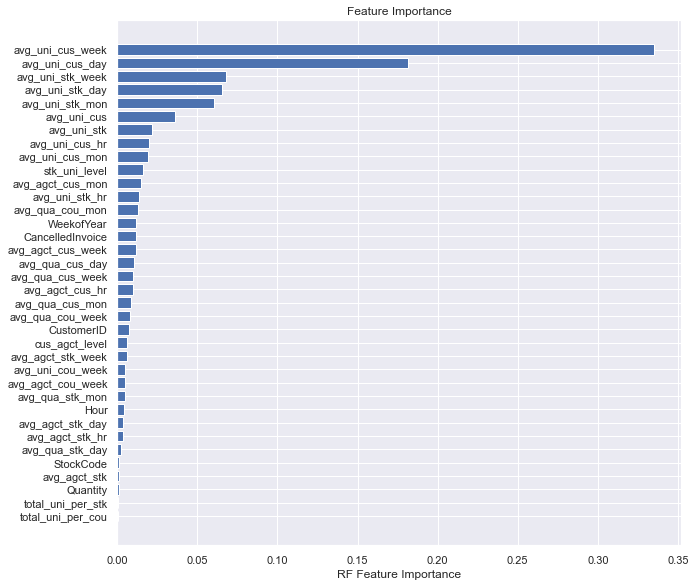

In [26]:
# Random Forest in-built functionaity to provide coefficient values of all features. Gives good insight on important features
col_names = x_train.columns
importances = model.feature_importances_
idx = np.argsort(importances)
plt.title(f'Feature Importance')
plt.barh(range(len(idx)), importances[idx], align='center')
plt.yticks(range(len(idx)), [col_names[i] for i in idx])
plt.xlabel('RF Feature Importance')
plt.show()

Two more techniques for feature selection:
* 1. Pearson Correlation- high +ve and -ve values features can be dropped 
* 2. Predictive Power Score- high values close 1 imples the y feature can be predicted by x feature,                                    this y feature can be dropped. PPS can find Non Linear Relationships.

In [27]:
# List of Final selected features for all 3 models : Random Forest, Xgboost, LightGBM
rf_features = ['CustomerID', 'WeekofYear', 'CancelledInvoice', 'stk_uni_level', 'total_uni_per_stk', 'total_uni_per_cou', 'avg_uni_stk_mon', 'avg_uni_stk_week', 'avg_uni_stk_day', 'avg_uni_stk_hr', 'avg_uni_cus_mon', 'avg_uni_cus_week', 'avg_uni_cus_hr', 'avg_agct_cus_mon', 'avg_agct_cus_week', 'avg_agct_cus_hr', 'avg_qua_cus_mon', 'avg_qua_cus_week', 'avg_qua_cus_day', 'avg_uni_cus', 'avg_uni_stk']

xgb_features = ['CustomerID', 'Hour', 'stk_uni_level', 'cus_agct_level', 'avg_uni_stk_mon', 'avg_uni_stk_week', 'avg_uni_stk_day', 'avg_uni_stk_hr', 'avg_qua_stk_mon', 'avg_uni_cus_mon', 'avg_uni_cus_week', 'avg_agct_cus_week', 'avg_agct_cus_hr', 'avg_qua_cus_week', 'avg_qua_cus_day', 'avg_qua_cou_mon', 'avg_qua_cou_week', 'avg_uni_cus', 'avg_uni_stk']

lgm_features = ['StockCode', 'Quantity', 'CustomerID', 'stk_uni_level', 'avg_agct_stk_week', 'avg_agct_stk_day', 'avg_agct_stk_hr', 'avg_qua_stk_mon', 'avg_qua_stk_day', 'avg_uni_cus_mon', 'avg_uni_cus_week', 'avg_uni_cus_day', 'avg_uni_cus_hr', 'avg_agct_cus_week', 'avg_uni_cou_week', 'avg_agct_cou_week', 'avg_uni_cus', 'avg_uni_stk', 'avg_agct_stk']


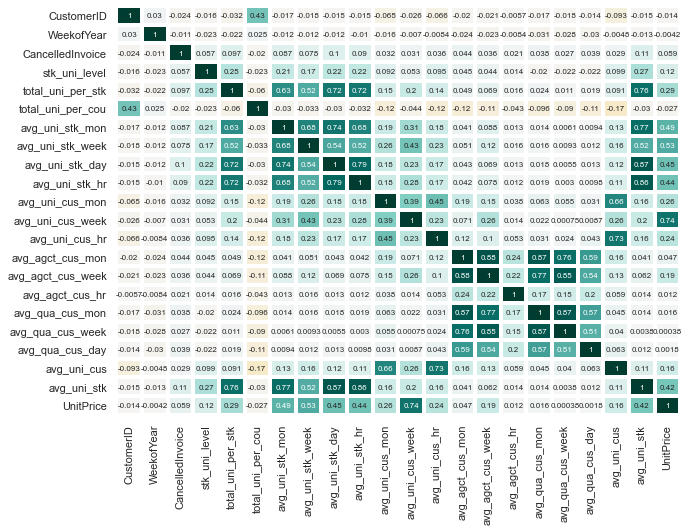

In [28]:
# Pearson Correlation- Features with high linear relations can be found out. For demo purposed i am directly using selected feature as the plot will be too big for all features.
df_ss = df_train[rf_features + ['UnitPrice']] 
ax = sns.heatmap(df_ss.corr(), vmin=-1, vmax=1, cmap="BrBG", linewidths=3, xticklabels=True,annot=True, annot_kws={"fontsize":8}, cbar=False)
ax.figure.subplots_adjust(bottom = 0.25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

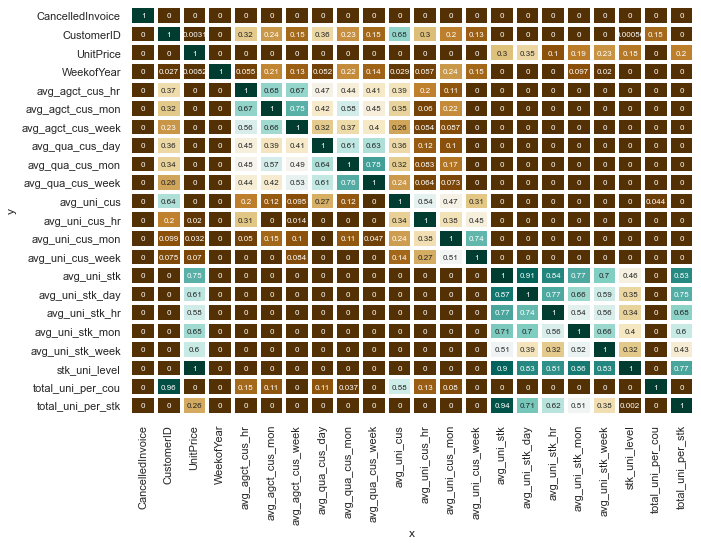

In [29]:
# Predictive Power score- The PPS is an asymmetric, data-type-agnostic score that can detect linear or non-linear relationships between two columns. The score ranges from 0 (no predictive power) to 1 (perfect predictive power). It can be used as an alternative to the correlation (matrix).
df_ss = pps.matrix(df_train[rf_features + ['UnitPrice']]).pivot(columns='x', index='y', values='ppscore')    
ax = sns.heatmap(df_ss, vmin=0, vmax=1, cmap="BrBG", linewidths=3, xticklabels=True,annot=True, annot_kws={"fontsize":8}, cbar=False)
ax.figure.subplots_adjust(bottom = 0.25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Same process has been applied for all 3 models (Random Forest Regressor, Xgboost Regressor, LightGBM Regressor) used later to extract important features. Every model fits the data in different way, so important features will differ in all. Seperate lists has been created to store these features above.

# Model Training & Prediction

Trained 3 models independantly considering seperate feature list. Randomized Search was used in the background for hyperparameter tuning of these models. Code not included here for execution speed purpose.

In [30]:
submission = pd.DataFrame()

In [31]:
x_train = df_train[rf_features]
x_valid = df_test[rf_features] 

model = RandomForestRegressor(n_estimators= 100, min_samples_split= 4, min_samples_leaf= 3, max_depth= 9,                                   n_jobs=-1, random_state=42)
print("RF Cross Validation RMSE Score",-np.mean(cross_val_score(model, x_train, df_train.UnitPrice.values,                                                  cv=5, scoring ='neg_root_mean_squared_error')))

#Training on full data
model.fit(x_train, df_train.UnitPrice.values) 
valid_preds = model.predict(x_valid)
prediction = pd.Series(valid_preds)
if any(prediction<0):
    prediction[prediction <0] = prediction[prediction>0].nsmallest(n=10).mean()
submission['rf'] = prediction


RF Cross Validation RMSE Score 12.80539714463951


In [32]:
x_train = df_train[xgb_features]
x_valid = df_test[xgb_features]

model = xgb.XGBRegressor(subsample= 0.8, reg_lambda= 0.1, reg_alpha= 0.3, min_child_weight= 5, 
                            max_depth = 5, learning_rate= 0.1, gamma = 0.7, colsample_bytree = 0.8,                                     n_jobs=-1, random_state=42)
print("XGBR Cross Validation RMSE Score",-np.mean(cross_val_score(model, x_train,                                                                               df_train.UnitPrice.values, cv=5, 
                                                     scoring ='neg_root_mean_squared_error')))

#Training on full data
model.fit(x_train, df_train.UnitPrice.values)
valid_preds = model.predict(x_valid)
prediction = pd.Series(valid_preds)
if any(prediction<0):
    prediction[prediction <0] = prediction[prediction>0].nsmallest(n=10).mean()
submission['xgb'] = prediction 


XGBR Cross Validation RMSE Score 12.226130391540696


In [33]:
x_train = df_train[lgm_features]
x_valid = df_test[lgm_features]

model = lgb.LGBMRegressor(n_jobs=-1, random_state=42, subsample= 0.6, reg_lambda= 1.0, reg_alpha= 0.3,                                  num_leaves= 110, n_estimators= 300, min_child_samples= 50, max_depth= 11,                                   learning_rate= 0.1, colsample_bytree= 0.8)
print("LGBMR Cross Validation RMSE Score",-np.mean(cross_val_score(model, x_train,                                                                               df_train.UnitPrice.values, cv=5, 
                                                     scoring ='neg_root_mean_squared_error')))

#Training on full data
model.fit(x_train, df_train.UnitPrice.values) 
valid_preds = model.predict(x_valid)
prediction = pd.Series(valid_preds)
if any(prediction<0):
    prediction[prediction <0] = prediction[prediction>0].nsmallest(n=10).mean()
submission['lgm'] = prediction 

LGBMR Cross Validation RMSE Score 13.881728554965761


# Ensemble & Submission

Prediction from all 3 models have been merged to provide better stability and accuracy. 
* Keep in mind that Tree based models can give negative values sometimes in regression even though target is always postilve. This is a known behaviour due to unseen data and gradient has no bounds in tree based models.
* Based on Cross validation score of all 3 models we can assign weights to predictions(ensemble) to get best submission score.

In [34]:
submission['UnitPrice'] = 0.25*submission['rf'] + 0.55*submission['xgb']+ 0.20*submission['lgm']
submission['UnitPrice'].to_csv('final_submission.csv', header=['UnitPrice'], index=False)
print(prediction[0:10])

0     1.681567
1     2.656849
2     6.764915
3     3.482404
4    13.695765
5     0.018032
6     6.299878
7     2.915429
8     2.895658
9     3.762829
dtype: float64
